# Attention-BiLSTM Classifier gradients

In [1]:
# Import code from file in upper directory
import sys, os
sys.path.append(os.getcwd() + os.sep + os.pardir)

from tweet_data import TweetsBaseDataset, get_mapping
from attn_lstm import AttentionBiLSTMClassifier
from train import load_model

import torch
import numpy as np
import matplotlib.pyplot as plt

We start by instantiating a model with empty embeddings, and then loading the weights from an already trained model.

In [2]:
embeddings = np.empty((10002, 300), dtype=np.float32)
model = AttentionBiLSTMClassifier(embeddings)
model = load_model(model, '../runs/attbilstm-Sep28_14-29-40_gpu-deep-learner/best-ckpt.pt')

Now we load the dataset to evaluate the model.

In [3]:
test_set = TweetsBaseDataset.load('../data/test/us_test.set')
idx_to_word = {i: word for word, i in test_set.vocabulary.items()}
emoji_map = get_mapping('../data/mapping/us_mapping.txt')

Loaded dataset with 50000 tweets, 10002 unique tokens


We will now check the gradient of the maximum score predicted by the model with respect to the input, to have an idea of the influence of words in the tweet on the prediction.

In [4]:
def inspect_sample(index):    
    # Get a sample tweet
    inputs, y_true, index = test_set[index]
    # Build mini-batch of size 1 to pass it to the model
    inputs = inputs.unsqueeze(1)
    length = torch.tensor([inputs.shape[0]])

    # Get prediction
    outputs = model(inputs, length).squeeze()
    y_pred = torch.argmax(outputs)

    # Compute the gradient of the logit for the predicted emoji
    model.zero_grad()
    outputs[y_pred].backward()
    # Get the gradients for words in the input
    word_grads = model.embeddings.weight.grad[inputs.squeeze()]
    grad_norms = torch.norm(word_grads, dim=1).data.numpy()

    # Plot gradients for each word
    words = [idx_to_word[idx.item()] for idx in inputs]
    x = np.arange(len(words))
    plt.figure(figsize=(0.5*len(words), 5))
    plt.bar(x, grad_norms)
    plt.xticks(x, words, rotation='45')
    plt.title('Norm of gradient')

    print('Prediction: {}'.format(emoji_map[y_pred.item()]))
    print('Truth: {}'.format(emoji_map[y_true.item()]))

Prediction: 🎄
Truth: 🎄


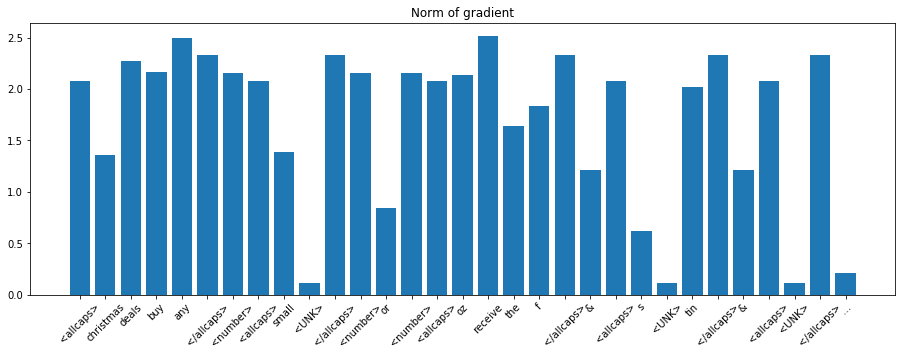

In [6]:
inspect_sample(5)